In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from astroML.datasets import sdss_corrected_spectra

In [2]:
from astropy.table import Table, join, hstack, vstack, Column
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord, Galactocentric, Galactic, Distance
from astropy.io import fits
from astropy.modeling import models, fitting


In [3]:
# 4258
# import science image and organize data
hdulist = fits.open('ngc4258_combined (1).fits')

# flux
sci=hdulist[1]

# variance
var = hdulist[2]
name_object=sci.header['OBJECT']
pscale = sci.header['PIXSCALE']

In [4]:
#This creates the wavelength array:

lambda0=sci.header['CRVAL3']
dlambda=sci.header['CD3_3']
s=range(sci.header['NAXIS3'])
lambda01=np.array(s)*dlambda+lambda0

# retrieve pixel scale to convert pixels to arcseconds
pscale = sci.header['PIXSCALE']

In [5]:
xcen = int(sci.header['CRPIX1'])
ycen = int(sci.header['CRPIX2'])


In [6]:
#  Mask out everything but center with flux measurements
maskradius = 20

cut = sci.data[:, ycen-maskradius:ycen+maskradius+1, xcen-maskradius:xcen+maskradius+1]

In [7]:
#find brightest pixel
yb, xb = np.where(cut.mean(0)==max(cut.mean(0)[~np.isnan(cut.mean(0))]))

In [8]:
#  new central pixel
xcen = maskradius
ycen = maskradius

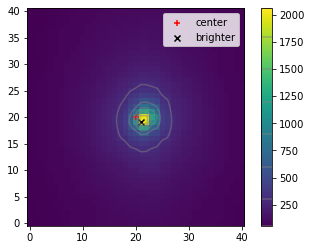

In [9]:
fig = plt.figure()
im = plt.imshow(cut.mean(0), origin='lower')
cs2 = plt.contour(cut.mean(0), colors='gray', alpha=.5)
plt.scatter(xcen, ycen, color='r', marker='+', label='center')
plt.scatter(xb,yb, marker='x', color='k', label ='brighter')
cbar = fig.colorbar(im)
cbar.add_lines(cs2)
plt.legend()

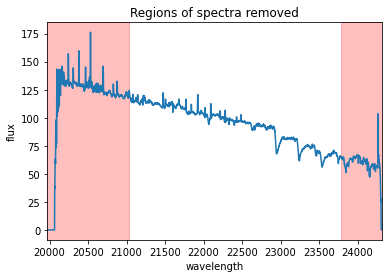

In [10]:
# plot showing regions of instrument noise and cuts made to remove them
plt.plot(lambda01, np.mean(sci.data.mean(1),axis=1))
plt.axvspan(lambda01[0], lambda01[500], color='r', alpha=.25)
plt.axvspan(lambda01[-250], lambda01[-1], color='r', alpha=.25)
plt.xlim(lambda01[0], lambda01[-1])
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.title('Regions of spectra removed');

I cut out a lot here in an attempt to removed the skylines. I dont think its the best method.

In [11]:
# mask out edges of spectra affected by instrument
lambmask = 500
lambda1 = (np.array(s)*dlambda+lambda0)[lambmask:-int(lambmask/2)]

In [12]:
# convert 3d array into 2d array that PCA can read
flux0 = []

for i in range(cut.shape[2]):
    for j in range(cut.shape[1]):

        flucks = cut[:,j,i][lambmask:-int(lambmask/2)] 
        flux0.append( flucks )
        
flux0 = np.array(flux0)

In [13]:
# translate brightest pixel to new index
# brightest pixel
i = xb
j = yb

# equation to change (x,y) index to new index range
idx = int(j+len(cut[0,:,0])*i)

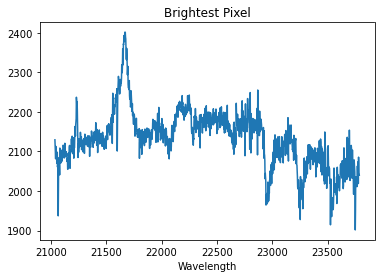

In [14]:
# spectra of brightest pixel
plt.plot(lambda1, flux0[idx])
plt.title('Brightest Pixel')
plt.xlabel('Wavelength');

In [15]:
#scale data
x = StandardScaler().fit_transform(flux0.T)

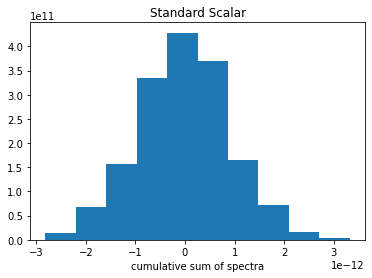

In [16]:
# this is a histogram of the rough approximation of the integrated flux of each spectra. The textbook said they should all approach unity. 
xint = []
for i in range(len(x.T)):
    xint.append(np.cumsum(x.T[i])[-1])
    
plt.hist(xint, density=True)
plt.xlabel('cumulative sum of spectra')
plt.title('Standard Scalar');

Text(0.5, 1.0, 'Mean Spectrum (scaled)')

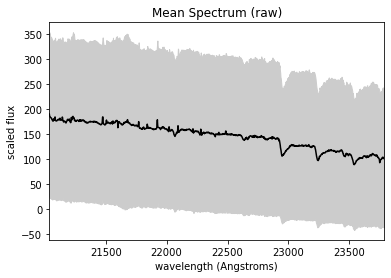

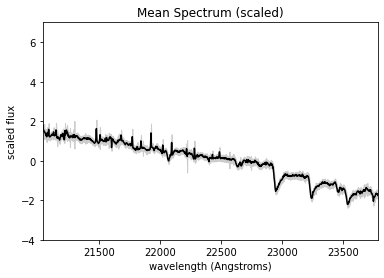

In [17]:
# plot the mean spectrum and std of raw data and scaled data
mu = flux0.mean(0)
std = flux0.std(0)
plt.plot(lambda1, mu, color='black')
plt.fill_between(lambda1, mu - std, mu + std, color='#CCCCCC')
plt.xlim(lambda1[0], lambda1[-1])
# plt.ylim(-4,7)
plt.xlabel('wavelength (Angstroms)')
plt.ylabel('scaled flux')
plt.title('Mean Spectrum (raw)')

plt.figure()
mu = x.T.mean(0)
std = x.T.std(0)
plt.plot(lambda1, mu, color='black')
plt.fill_between(lambda1, mu - std, mu + std, color='#CCCCCC')
plt.xlim(lambda1[0], lambda1[-1])
plt.ylim(-4,7)
plt.xlabel('wavelength (Angstroms)')
plt.ylabel('scaled flux')
plt.title('Mean Spectrum (scaled)')

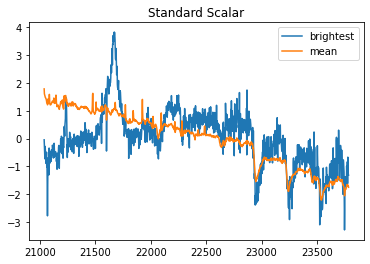

In [18]:
# compare brightest Pixel and mean spectra

plt.figure()
plt.plot(lambda1, x.T[idx], label='brightest')
plt.plot(lambda1, np.mean(x.T, axis=0), label='mean')
plt.title('Standard Scalar')
# plt.axhline(np.mean(x.T[idx]), color='k', linestyle='dotted', label = 'brightest pixel:\nmean: '+str(np.mean(x.T[idx])) +'\nstd: '+ str(np.std(x.T[idx])) )
plt.legend()



In [19]:
# perform PCA on scaled data
pcax = PCA(n_components=4, random_state=0, svd_solver='randomized')

# pixel weighting by PCA components
x_projected = pcax.fit_transform(x.T)

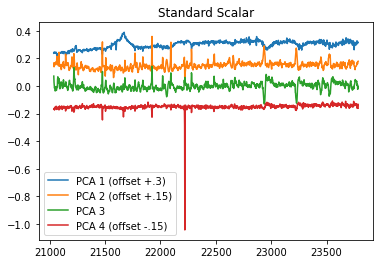

In [20]:
# inspect eigenfluxes
plt.plot(lambda1, pcax.components_[0]+.3, label='PCA 1 (offset +.3)')
plt.plot(lambda1, pcax.components_[1]+.15, label='PCA 2 (offset +.15)')
plt.plot(lambda1, pcax.components_[2], label='PCA 3')
plt.plot(lambda1, pcax.components_[3]-.15, label='PCA 4 (offset -.15)')
plt.legend()
plt.title('Standard Scalar');

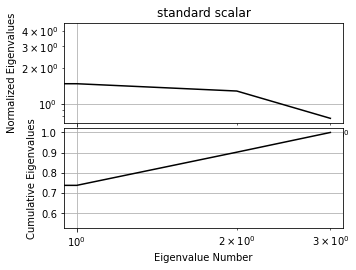

In [21]:
# plots of the eigenvalues vs number of components (stolen from the textbook) this is more useful when we use lots of components
# it helps us decide how many components are needed to best describe the data

evals = pcax.explained_variance_
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]

#------------------------------------------------------------
# plot the eigenvalues
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(hspace=0.05, bottom=0.12)

ax = fig.add_subplot(211, xscale='log', yscale='log')
ax.grid()
ax.plot(evals, c='k')
ax.set_ylabel('Normalized Eigenvalues')
ax.xaxis.set_major_formatter(plt.NullFormatter())
# ax.set_ylim(5E-5, 100)
plt.title('standard scalar')

ax = fig.add_subplot(212, xscale='log')
ax.grid()
ax.semilogx(evals_cs, color='k')
ax.set_xlabel('Eigenvalue Number')
ax.set_ylabel('Cumulative Eigenvalues')
# ax.set_ylim(0., 1.00)

plt.show()

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [23]:
# create custom tick marks to display arcseconds instead of pixel number
ticks = list(range(0,41,10))

# What those pixel locations correspond to in data coordinates.
# Also set the float format here
ticklabels = ["{:6.2f}".format(i) for i in (np.array(ticks)-25)*pscale]

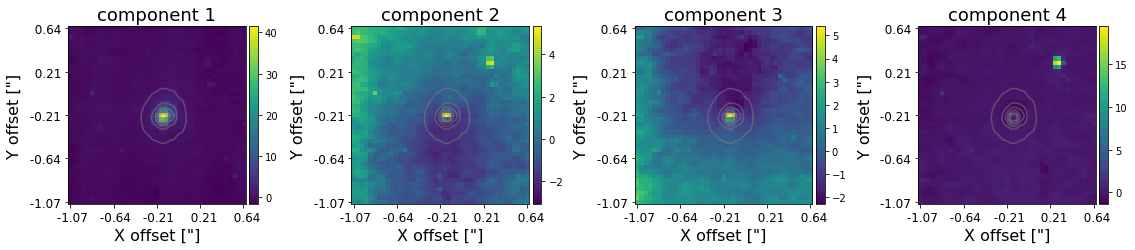

In [24]:
# plot image with each pixel colored by principal component weight. Each image is overlaid with contour plot of the mean flux

fig = plt.figure(figsize=(16,24))

for i in range(len(pcax.explained_variance_)):
    plt.subplot(1, len(pcax.explained_variance_), i+1)
    ax = plt.gca()
    im = ax.imshow(x_projected[:,i].reshape(cut[0].shape).T,origin='lower')
#     plt.scatter(xb,yb, color='k', marker='x')
    cs2 = plt.contour(cut.mean(0), colors='gray', alpha=.5)    
    plt.title('component '+str(i+1), fontsize=18)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels, fontsize=12)
    ax.set_xlabel('X offset ["]', fontsize=16)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels, fontsize=12)
    ax.set_ylabel('Y offset ["]', fontsize=16)
    
plt.tight_layout()
